**автоматический переводчик на основе рекуррентных нейросетей seq2seq**

кодируем слова word2vec

Евгений Борисов <borisov.e@solarl.ru>


----

## Библиотеки

In [1]:
import numpy as np
import re
import gzip

import pandas as pd
pd.options.display.max_colwidth = 200  


In [2]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Учебные данные

In [3]:
with gzip.open('../data/text/rus-eng/rus.txt.gz','rt',encoding='utf8') as f: 
    pair = pd.DataFrame([ p.split('\t') for p in f.read().split('\n') if p.strip() ])

In [4]:
# with open('../data/text/pairs.txt','rt',encoding='utf8') as f: 
#     pair = pd.DataFrame([ p.split('%%') for p in f.read().split('\n') if p.strip() ])

In [5]:
pair.columns=['Q','A']
pair['Q'] = pair['Q'].str.strip()
pair['A'] = pair['A'].str.strip()

In [6]:
ppr(pair)
pair.sample(9)

записей: 336 666


,Q,A
90963,Tom doesn't know Mary.,Том не знаком с Мэри.
60445,I think I need help.,"Думаю, мне нужна помощь."
8711,I hate coffee.,Ненавижу кофе.
83096,Can I give you a hand?,Я могу дать тебе руку?
263589,Tom didn't come to school yesterday.,Том вчера не пришел в школу.
87972,I've started bleeding.,У меня началось кровотечение.
322675,How did you know that Tom was the one who did that?,"Откуда вы знали, что это Том сделал?"
192440,How did you find out about us?,Как ты про нас узнал?
187971,Tom wants to be a lumberjack.,Том хочет быть лесорубом.


In [7]:
pair = pair.iloc[100000:110000]

## Чистим тексты

In [8]:
pair['Q_clean'] = pair['Q'].str.lower()
pair['Q_clean'] = pair['Q_clean'].str.replace(r'([,.?!])', r' \1 ')

pair['A_clean'] = pair['A'].str.lower()
pair['A_clean'] = pair['A_clean'].str.replace(r'([,.?!])', r' \1 ')

# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'(\W)', ' \1 ', s))
# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s)) 

In [9]:
# добавляем "служебные" слова - начало и конец последовательности
# pair['Q_clean'] = pair['Q_clean'].str.split() + ['<START>']
pair['Q_clean'] = ['<START>'] + pair['Q_clean'].str.split() + ['<EOS>']
pair['A_clean'] = ['<GO>'] + pair['A_clean'].str.split() + ['<EOS>']

In [10]:
pair[['Q_clean','A_clean']].sample(9)

,Q_clean,A_clean
105948,"[<START>, we, have, run, out, of, gas, ., <EOS>]","[<GO>, у, нас, кончился, бензин, ., <EOS>]"
105168,"[<START>, tom, told, mary, a, secret, ., <EOS>]","[<GO>, том, поведал, мэри, секрет, ., <EOS>]"
109026,"[<START>, do, you, need, an, umbrella, ?, <EOS>]","[<GO>, вам, нужен, зонт, ?, <EOS>]"
105345,"[<START>, tom, wanted, you, to, know, ., <EOS>]","[<GO>, том, хотел, ,, чтобы, вы, узнали, ., <EOS>]"
104445,"[<START>, tom, is, your, son, ,, right, ?, <EOS>]","[<GO>, том, —, твой, сын, ,, верно, ?, <EOS>]"
109393,"[<START>, don't, tell, tom, and, mary, ., <EOS>]","[<GO>, не, говори, тому, и, мэри, ., <EOS>]"
102966,"[<START>, they're, both, unmarried, ., <EOS>]","[<GO>, они, обе, не, замужем, ., <EOS>]"
109991,"[<START>, he, pretended, to, be, sick, ., <EOS>]","[<GO>, он, притворился, больным, ., <EOS>]"
106483,"[<START>, what, do, you, plan, to, do, ?, <EOS>]","[<GO>, что, ты, планируешь, делать, ?, <EOS>]"


---

In [11]:
# считаем количество слов
pair['lenQ'] = pair['Q_clean'].str.len()
pair['lenA'] = pair['A_clean'].str.len()
# pair.describe()

In [12]:
# # определяем максимальную длинну последовательности
# pair['lenQ'].quantile(0.95),  pair['lenA'].quantile(0.95)

In [13]:
sent_len_a_max = pair['lenA'].max()
sent_len_q_max = pair['lenQ'].max()

In [14]:
# выстраиваем входные последовательности в обратном порядке
# и выравниваем длинну последовательностей,
# дополняем короткие словом "служебным" словом,
pad = ['<PAD>']*sent_len_q_max
pair['Q_clean'] = pair['Q_clean'].apply( lambda t: pad[len(t):] + t )
# pair['Q_clean'] = pair['Q_clean'].apply( lambda t: pad[len(t):] + list(reversed(t)) )
# pair['Q_clean'] = pair['Q_clean'].apply( lambda t: t + pad[len(t):] )

pad = ['<PAD>']*sent_len_a_max
pair['A_clean'] = pair['A_clean'].apply( lambda t: t + pad[len(t):] )

In [15]:
pair[['Q_clean','A_clean']].sample(9)

,Q_clean,A_clean
108044,"[<PAD>, <PAD>, <PAD>, <PAD>, <START>, you're, very, attractive, ., <EOS>]","[<GO>, ты, очень, привлекательна, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
105203,"[<PAD>, <START>, tom, told, me, to, do, that, ., <EOS>]","[<GO>, том, сказал, мне, ,, чтобы, я, это, сделал, ., <EOS>, <PAD>, <PAD>]"
101590,"[<PAD>, <PAD>, <START>, of, course, i, was, joking, ., <EOS>]","[<GO>, конечно, ,, я, шутил, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
103827,"[<PAD>, <START>, tom, got, out, of, the, car, ., <EOS>]","[<GO>, том, вышел, из, машины, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
101679,"[<PAD>, <PAD>, <PAD>, <START>, please, leave, this, room, ., <EOS>]","[<GO>, выйди, из, этой, комнаты, ,, пожалуйста, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>]"
102451,"[<PAD>, <PAD>, <START>, that's, why, i, came, here, ., <EOS>]","[<GO>, поэтому, я, сюда, и, пришёл, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
107296,"[<PAD>, <START>, why, is, tom, mad, at, mary, ?, <EOS>]","[<GO>, почему, том, злится, на, мэри, ?, <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
103486,"[<PAD>, <PAD>, <START>, tom, can, read, and, write, ., <EOS>]","[<GO>, том, умеет, читать, и, писать, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
106277,"[<PAD>, <PAD>, <PAD>, <PAD>, <START>, we're, learning, chinese, ., <EOS>]","[<GO>, мы, учим, китайский, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"


## Кодируем тексты

In [16]:
# data = pair['Q_clean'].values.tolist() + pair['A_clean'].values.tolist()

In [17]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 128

w2v_q = Word2Vec( pair['Q_clean'].values.tolist(), min_count=1, size=w2v_size, window=4, workers=4)
w2v_a = Word2Vec( pair['A_clean'].values.tolist(), min_count=1, size=w2v_size, window=4, workers=4)

CPU times: user 1.01 s, sys: 34.3 ms, total: 1.05 s
Wall time: 736 ms


In [18]:
# w2v_q_vocab = sorted([w for w in w2v_q.wv.vocab])
# ppr(w2v_q_vocab)
# w2v_a_vocab = sorted([w for w in w2v_a.wv.vocab])
# ppr(w2v_a_vocab)

In [19]:
# ii = np.random.permutation(len(w2v_q_vocab))[:10]
# for i in ii:
#     w = w2v_q_vocab[i]
#     ww = [ v[0] for v in w2v_q.wv.most_similar(w, topn=5) ]
#     print( w,':',ww )

In [20]:
# ii = np.random.permutation(len(w2v_a_vocab))[:10]
# for i in ii:
#     w = w2v_a_vocab[i]
#     ww = [ v[0] for v in w2v_a.wv.most_similar(w, topn=5) ]
#     print( w,':',ww )

---

In [21]:
# c = w2v_a.wv['<GO>']
# w2v_a.wv.similar_by_vector(c)[0][0] 
# c.min(), c.max()

---

In [22]:
pair['Q_code'] = pair['Q_clean'].apply(lambda t: [ w2v_q.wv.get_vector(w) for w in t ] )
pair['A_code'] = pair['A_clean'].apply(lambda t: [ w2v_a.wv.get_vector(w) for w in t ] )

In [23]:
# pair[['Q_code','A_code']].sample(3)


-----

In [24]:
# ppr(pair)

In [25]:
# pair = pair.sample(1000)
# pair = pair.sample(283800)
# pair = pair.sample(600)

In [26]:
encoder_input_data = np.stack( pair['Q_code'].values ).astype(np.float32)

decoder_input_data = np.stack( pair['A_code'].values )[:,:-1,:].astype(np.float32)
decoder_target_data = np.stack( pair['A_code'].values )[:,1:,:].astype(np.float32)

encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 10, 128), (10000, 12, 128), (10000, 12, 128))

In [27]:
# np.abs(encoder_input_data).max(), np.abs(decoder_input_data).max()

## Строим нейросеть

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [29]:
latent_dim = 256  # размер сети

In [30]:
encoder_inputs = Input(shape=(None, w2v_size))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
from keras import backend as K
def custom_activation(x):  return (K.tanh(x)*3.)
# model.add(Dense(32 , activation=custom_activation))

Using TensorFlow backend.


In [32]:
decoder_inputs = Input(shape=(None, w2v_size))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

# decoder_dense = Dense(w2v_size)
# decoder_dense = Dense(w2v_size, activation='softmax')
# decoder_dense = Dense(w2v_size, activation='tanh')
# decoder_dense = Dense(w2v_size, activation='sigmoid')
decoder_dense = Dense(w2v_size, activation=custom_activation)

decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 394240      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  394240      input_2[0][0]                    
                                                                 lstm[0][1]                       
          

In [46]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(loss='mse', optimizer='rmsprop')
# model.compile(loss='mse', optimizer='adam')
# model.compile(loss='mse', optimizer='sgd')

In [51]:
%%time 

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=50,
          epochs=10,
          validation_split=0.1
        ) 

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 16s 2ms/sample - loss: 0.0102 - val_loss: 0.0111
Epoch 2/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0100 - val_loss: 0.0111
Epoch 3/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0099 - val_loss: 0.0108
Epoch 4/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0097 - val_loss: 0.0107
Epoch 5/10
9000/9000 [==============================] - 16s 2ms/sample - loss: 0.0095 - val_loss: 0.0108
Epoch 6/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0094 - val_loss: 0.0112
Epoch 7/10
9000/9000 [==============================] - 16s 2ms/sample - loss: 0.0092 - val_loss: 0.0107
Epoch 8/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0091 - val_loss: 0.0112
Epoch 9/10
9000/9000 [==============================] - 17s 2ms/sample - loss: 0.0089 - val_loss: 0.0112
Epoch 1

## Проверяем результат

In [52]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [53]:
def decode_sequence(input_seq):
    # генерируем состояние энкодера
    states_value = encoder_model.predict(input_seq)

    # вход декодера - последовательность из одного слова GO
    output_w2v = w2v_a.wv['<GO>'].reshape([1,1,w2v_size])

    # выходная последовательность
    decoded_sentence = []
    
    for i in range(sent_len_a_max): 
        output_w2v, h, c = decoder_model.predict([output_w2v] + states_value)

        # декодируем cлово
        cc = output_w2v.reshape(w2v_size)
        w = w2v_a.wv.similar_by_vector(cc)[0][0] 
        
        # если очередное слово это EOS
        if(w=='<EOS>'): break # то завершаем работу

        decoded_sentence.append(w)
       
        states_value = [h,c] # обновляем состояние сети

    return ' '.join(decoded_sentence)

In [54]:
ii = np.random.permutation(len(encoder_input_data))[:10]
for seq_index in ii:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print( pair.iloc[seq_index]['Q'],' -> ', decoded_sentence )

Tom applied for asylum.  ->  том говорит мне , .
Please turn off the TV.  ->  она хотите мне хотите быть ! важно бостоне .
Don't give up so easily.  ->  ты ему где как ?
Tom and I aren't fools.  ->  том хочешь сделал мне хотите победит .
Everybody wanted to eat.  ->  он бы мне сделал сделал мэри !
Read the article again.  ->  хочешь хотите , сделал сделал шляпу предложение важно .
There's a storm coming.  ->  ему всегда сказал сделал
I'm glad you said that.  ->  я говорит , пожалуйста так здесь ! рождения ?
What are you afraid of?  ->  должен ты мне хочет ? важно бостоне .
Aren't these your books?  ->  хочешь просто мне победит ? важно <PAD> .


----

In [55]:
import matplotlib.pyplot as plt

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

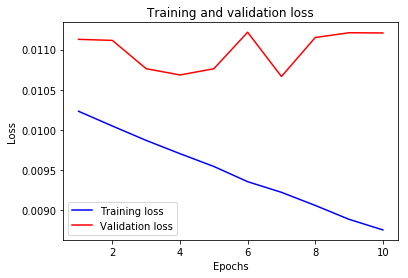

In [57]:
# acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
# plt.clf()   # clear figure
# acc_values = history_dict['acc']
# val_acc_values = history_dict['val_acc']

# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

---

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

In [45]:
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

if tf.test.is_built_with_cuda():
    print('GPU devices:\n  ',
        [ [x.name, x.physical_device_desc] 
          for x in device_lib.list_local_devices() 
          if x.device_type == 'GPU' ]
    )
    print('default GPU device:', tf.test.gpu_device_name() )

else:
    print('no GPU device found')
    

tensorflow: 1.13.1
keras: 2.2.4-tf
GPU devices:
   [['/device:GPU:0', 'device: 0, name: GeForce GT 730, pci bus id: 0000:01:00.0, compute capability: 3.5']]
default GPU device: /device:GPU:0
